# A* Search

We will be trying to find and visualize the path between Equestrian Statue of Edward VII and Bahen Center of Technology around Toronto University campus using A* search

**PQ** &larr; min heap according to **A-star heuristic**  
**A-star heuristic** &larr; sum of straight-line distance between the node to _goal_ and the node to _destination_  


__A*-SEARCH__ ( _source_ , _destination_ ) __return__ a route     
&emsp;_frontier_ &larr; a **PQ** initialized with _source_ node  
&emsp;_explored_ &larr; empty    
&emsp;_found_ &larr; False    
&emsp;__while__  _frontier_ **is not** empty **and** _found_ **is** _False_  __do__    
&emsp;&emsp;&emsp;_node_ &larr; _frontier_.pop()    
&emsp;&emsp;&emsp;**add** _node_ **to** _explored_  
&emsp;&emsp;&emsp;__for__ _child_ __in__ _node_.expand() __do__   
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ _child_ __is not in__ _explored_ __and__ _child_ __is not in__ _frontier_   __then__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; __if__ _child_ __is__ _destination_ __then__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; _route_ &larr; _child_.route()  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; _found_ &larr; _True_  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;__add__ _child_ __to__ _frontier_    
&emsp;__return__  _route_

In [1]:
import osmnx as ox
import time
from collections import deque
from tqdm import tqdm
from utilities import *

Here OSMnx returns the largest connected component centered around the ```location point``` with specified ```dist``` on each side (w/n/e/s).

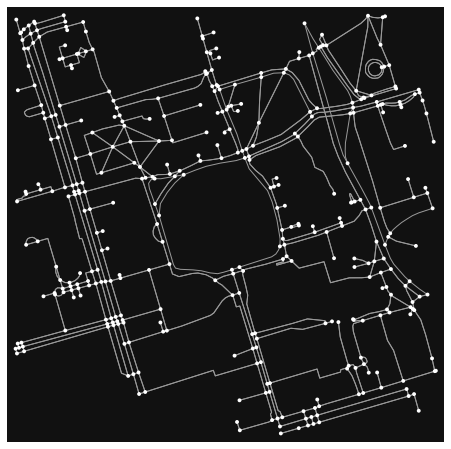

In [2]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
fig, ax = ox.plot_graph(G)

Here you need to specify which node from our graph is the source (Equestrian Statue of Edward VII) and which is the destination node (Bahen Center of Technology). You can do so by acquiring the decimal coordinates of the desired node and use [```osmnx.distance.get_nearest_node```](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.get_nearest_node) method

I used the aforementioned method and found that the nodes for destination and source are 389677909, 55808290 respectively

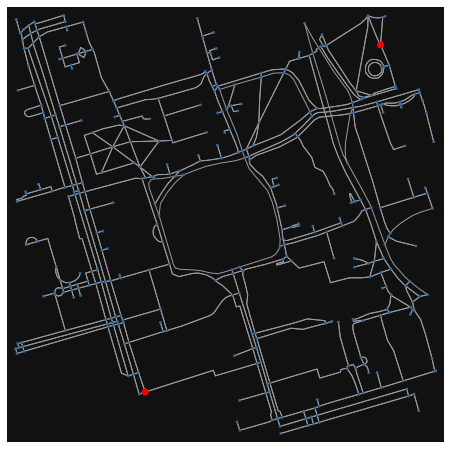

In [3]:
highlighted = [389677909, 55808290]

# marking both the source and destination node

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [4]:
draw_map(G, highlight = highlighted)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

Each node in our graph is represented as a dictionary with many attributes of no interest to us now, so manipulating them would obfuscate the algorithm jumping through hoops to get only one attribute from the dictionary. <b>so</b> we define class ```Node``` which only retains the data we need to be able to do searching and traversing, like the parent of the node (the one that produced it from its expansion) and the length of the edge between the parent and the node itself.

Please check its source code in ```./utilities/src/common.py``` to know how it captures the data from the graph. 

In [5]:
source(Node)

# The Algorithm

In [6]:
# first define the origin/source nodes as Node
origin = Node(graph = G, osmid = 55808290)
destination = Node(graph = G, osmid = 389677909)

## The Heuristic

What drives node expansion in A* algorithm is determining is choosing a node with the lowest heuristic value which is computer by summing the straight line distance between the node and the origin and the straight line distance between the node and the source so what we need here is a function that returns a data structure that pre-computes this value for each node.

In [7]:
source(astar_heuristic)
# x, y are longitude and latitude

In this implementation we assume that earth is flat which is acceptable approximation if our map is small but if we want to get it exactly right, we will need to compute [haversine formula](https://en.wikipedia.org/wiki/Haversine_formula).

You can do so by changing the measuring dist to `haversine_distance` instead the default `straight_distance`. If the area you query is relatively small, straight distance would give better results.

In [12]:
toGoal, toDestination = astar_heuristic(G, origin.osmid, destination.osmid, measuring_dist = haversine_distance)

In [13]:
%%time
route = []
frontier = list()

bar = tqdm(total=len(G)) # for the progress bar

frontier.append(origin)
explored = set()
found = False

while frontier and not found:
    bar.update(1); time.sleep(0.05)
    
    # choose a node based on its heuristic value
    node = min(frontier, key = lambda node : toGoal[node.osmid] + toDestination[node.osmid])
    frontier.remove(node)
    explored.add(node)
    
    # expand its children
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route = child.path()
                found = True
                continue
            frontier.append(child)

bar.close()
print("The route is \n\n",route, "\n\nits cost is\n\n", cost(G, route))

 19%|█▉        | 73/379 [00:03<00:16, 19.12it/s]

The route is 

 [55808290, 304891685, 55808284, 1252869817, 55808239, 389678268, 4953810915, 389678267, 24960090, 389678273, 1258698113, 389678151, 389678142, 2143489694, 389678141, 2143488528, 389678140, 389678139, 389678138, 3707407638, 6028561924, 6028561921, 389678131, 6028562356, 854322047, 389677908, 749952029, 389677909] 

its cost is

 838.9339999999999
CPU times: user 61.1 ms, sys: 15.3 ms, total: 76.4 ms
Wall time: 3.82 s


let's visualize that route

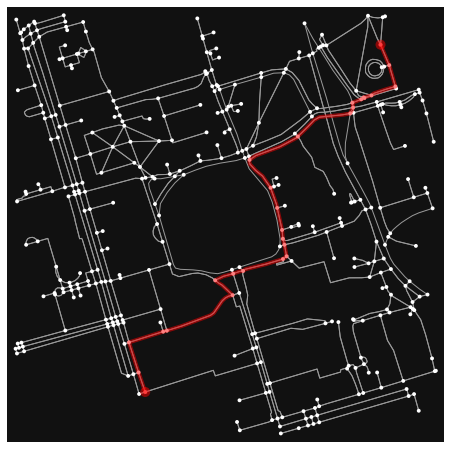

In [14]:
fig, ax = ox.plot_graph_route(G, route)

In [15]:
draw_route(G, route)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…